# Setup

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path 
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# Path to the data directory
data_dir = Path("./samples/")

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)
characters = sorted(characters)
print(f"Number of images found: {len(images)}")
print(f"Number of labels found: {len(labels)}")
print(f"Number of unique characters: {len(characters)}")
print(f"Characters present: {characters}")

Number of images found: 1021
Number of labels found: 1021
Number of unique characters: 23
Characters present: ['2', '3', '4', '5', '6', '7', '8', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'm', 'n', 'p', 's', 'w', 'x', 'y', 'z']


In [3]:
# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width = 300
img_height = 50

# Factor by which the image is going to be downsampled by the convolutional blocks.
# We will be using two convolution blocks and each block will have a pooling layer
# which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])
print(max_length)

6


# Preprocessing

In [4]:
# Mapping characters to integers
char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary=list(characters), num_oov_indices=0, mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]] 
    return x_train, x_valid, y_train, y_valid

def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

In [5]:
# Splitting data into training and validation sets
X_train, X_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))

print(f"X_Train shape: {X_train.shape}")
print(f"y_Train shape: {y_train.shape}")
print(f"X_valid shape: {X_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")

X_Train shape: (918,)
y_Train shape: (918,)
X_valid shape: (103,)
y_valid shape: (103,)


# Create dataset objects

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

# Model

In [7]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost
        
    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")
        
        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        
        # At test, just return the computed predictions
        return y_pred
    
def build_model():
    # Inputs the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")
    
    # First conv block
    x = layers.Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv1")(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)
    
    # Second conv block
    x = layers.Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv2")(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)
    
    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller.
    # The number of filters in the last layer is 64. 
    # Reshape accordingly before passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)
    
    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)
    
    # Output layer
    x = layers.Dense(len(characters) + 1, activation="softmax", name="dense2")(x)
    
    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)
    
    # Define the model 
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model

In [8]:
# Get the model
model = build_model()

In [9]:
model = tf.keras.models.load_model('model')

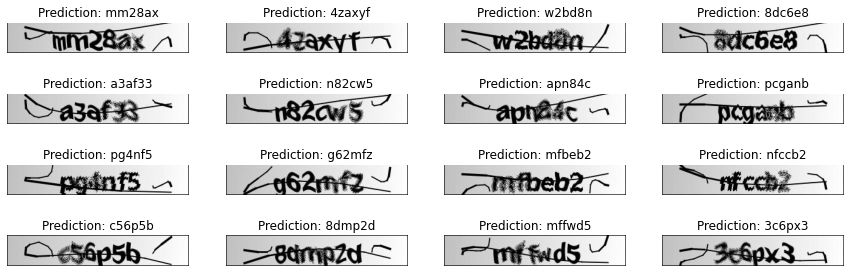

In [10]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, : max_length]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

# Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]
    
    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)
    
    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)
        
    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")        
plt.show()

In [11]:
import base64
from PIL import Image
from io import BytesIO
import urllib.request
import requests
import time
from selenium import webdriver
import timeit
import threading
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from datetime import datetime,timedelta
def saveImage(html,name):
    html = str(html)
    list = html.split('data:image/jpg;base64,')
    list2 = list[1].split('\'')
    data = list2[0]
    im = Image.open(BytesIO(base64.b64decode(data)))
    im.save(name+'.png', 'PNG')

In [12]:
def getCaptcha():
    test_images = list(map(str, list(Path("./test/").glob("*.png"))))
    test_labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in test_images]
    test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
    test_dataset = (
        test_dataset.map(
            encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
        )
        .batch(batch_size)
        .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    )
    for batch in test_dataset.take(1):
        pred_texts = decode_batch_predictions(prediction_model.predict(batch["image"]))
    return str(pred_texts[0])

dfyb34




<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd"> 
<html xmlns="http://www.w3.org/1999/xhtml" xml:lang="en">
<head>
	<base href="https://service2.diplo.de/rktermin/" />
	<meta http-equiv="Content-Type" content="text/html; charset=UTF-8" />
	<meta http-equiv="X-UA-Compatible" content="IE=9; IE=10; IE=11" />
	<title>
		RK-Termin
	</title>	
	<link rel="stylesheet" type="text/css" href="style_css/reset.css" />	
	<link rel="stylesheet" type="text/css" media="screen" href="style_css/screen.css" />	
	<link rel="stylesheet" type="text/css" media="print" href="style_css/print.css" />	
	<link rel="stylesheet" type="text/css" media="screen" href="style_css/rktermin.css" />
	
	<!--[if gte IE 7]><link rel="stylesheet" type="text/css" media="screen" href="style_css/ie7.css" /><![endif]-->	
	<!--[if gte IE 6]><link rel="stylesheet" type="text/css" media="screen" href="style_css/ie6.css" /><![endif]-->	
	<!--[if lte IE 
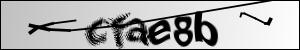

In [65]:
import requests
from requests import Session
import html
periodId = "51067"
dateStr = "29.09.2021"
previous_day_date_str = "28.09.2021"
locationCode = 'amma'
realmId = '16'
categoryId = '44'
last_page="https://service2.diplo.de/rktermin/extern/appointment_showForm.do?locationCode="+locationCode+"&realmId="+realmId+"&categoryId="+categoryId+"&dateStr="+dateStr+"&openingPeriodId="+periodId
first_page="https://service2.diplo.de/rktermin/extern/appointment_showDay.do?locationCode="+locationCode+"&realmId="+realmId+"&categoryId="+categoryId+"&dateStr="+previous_day_date_str
s = requests.session()
r = s.get(first_page)
k=s.cookies['JSESSIONID']
j=s.cookies['KEKS']
dates_page="https://service2.diplo.de/rktermin/extern/appointment_showDay.do;jsessionid=%s"%k
cookies1 = {
          'JSESSIONID':'%s'%k,
           'KEKS':'%s'%j
}
my_headers = { 
        "Content-Type": "application/x-www-form-urlencoded",
        "Cookie": f"JSESSIONID={k}; KEKS={j}",
        "Host": "service2.diplo.de",
        "Origin": "https://service2.diplo.de",
        "Sec-Fetch-Site": "same-origin",
        "Connection": "keep-alive",
        "Upgrade-Insecure-Requests": "1",
        "Sec-Fetch-User": "?1",
        "Sec-Fetch-Mode": "navigate",
        "Accept-Language": "en-US,en;q=0.5",
        "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:92.0) Gecko/20100101 Firefox/92.0"
}
saveImage(html.unescape(r.text), 'test/mmmmmm')
captcha=getCaptcha()
print(captcha)
data = {
  "captchaText":captcha,
  "rebooking": "",
  "token": "",
  "lastname": "",
  "firstname": "",
  "email": "",
  "locationCode": locationCode,
  "realmId": realmId,
  "categoryId": categoryId,
  "openingPeriodId": "",
  "date": previous_day_date_str,
  "dateStr": previous_day_date_str,
  "action:appointment_showDay": "Continue"
}
time.sleep(4)
m=s.post(dates_page, data=data,headers=my_headers,cookies=cookies1)
#print(m.text)
# while(datetime.now().second != 0):
#   pass
l=s.get(last_page,headers=my_headers,cookies=cookies1)
print(l.text)
saveImage(html.unescape(l.text), 'test/mmmmmm')
captcha=getCaptcha()
data = {
  "lastname": "ownuk",
  "firstname": "ilaman",
  "email": "ilamanownuk@yahoo.com",
  "emailrepeat": "ilamanownuk@yahoo.com",
  "fields[0].content": "X27917236",
  "fields[0].definitionId": "2245",
  "fields[0].index": "0",
  "fields[1].content": "008466768",
  "fields[1].definitionId": "132",
  "fields[1].index": "1",
  "fields[2].content": "hajigaldi",
  "fields[2].definitionId": "131",
  "fields[2].index": "2",
  "fields[3].content": "34156",
  "fields[3].definitionId": "7927",
  "fields[3].index": "3",
  "fields[4].content": "Passabholung/collection of passport/ استلام جواز السفر",
  "fields[4].definitionId": "7928",
  "fields[4].index": "4",
  "captchaText": captcha,
  "locationCode": "amma",
  "realmId": realmId,
  "categoryId": categoryId,
  "openingPeriodId": periodId,
  "date": dateStr,
  "dateStr": dateStr,
  "action:appointment_addAppointment": "Speichern" 
}

last_form_url_1="https://service2.diplo.de/rktermin/extern/appointment_showForm.do"
last_form_url_2="https://service2.diplo.de/rktermin/extern/appointment_addAppointment.do"
time.sleep(3.1)
result = s.post(last_form_url_2,data=data,headers=my_headers,cookies=cookies1,allow_redirects=True)
print(result.text)
print(captcha)

In [ ]:
url = "https://service2.diplo.de/rktermin/extern/appointment_showDay.do?locationCode=amma&realmId=16&categoryId=44&dateStr=24.08.2021"
urlirani = "https://service2.diplo.de/rktermin/extern/appointment_showDay.do?locationCode=eriw&realmId=351&categoryId=569&dateStr=09.05.2021"
x = datetime(2021,4,26,2,30,0)
#
from selenium.webdriver.chrome.options import Options
options = Options()
options.add_argument('--allow-running-insecure-content')
options.add_argument('--ignore-certificate-errors')
options.set_capability("acceptInsecureCerts", True)
browser = webdriver.Chrome(options=options)
#
browser.get(url)
saveImage(str(browser.page_source), 'test/mmmmmm')
test_images = list(map(str, list(Path("./test/").glob("*.png"))))
test_labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in test_images]
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = (
    test_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)
for batch in test_dataset.take(1):
    pred_texts = decode_batch_predictions(prediction_model.predict(batch["image"]))
browser.find_element_by_id('appointment_captcha_day_captchaText').send_keys(str(pred_texts[0]))
browser.execute_script("""document.querySelector("input[name='action:appointment_showDay']").click();""")
browser.execute_script("""document.querySelectorAll("a")[5].setAttribute("id", "ilaman");""")
while(x > datetime.now()):
    pass
browser.execute_script("""document.getElementById('ilaman').click();""")
browser.execute_script("""document.getElementsByClassName('arrow')[1].click();""")
#
browser.execute_script("""document.getElementById("appointment_newAppointmentForm").action = 'https://service2.diplo.de/rktermin/extern/appointment_showForm.do';""")
# browser.execute_script("""document.getElementById('appointment_newAppointmentForm_appointment_cancelAddAppointment').click();""")
# #
# s = time.time()
# start = datetime.now()
# saveImage(str(browser.page_source), 'test/mmmmmm')
# test_images = list(map(str, list(Path("./test/").glob("*.png"))))
# test_labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in test_images]
# test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
# test_dataset = (
#     test_dataset.map(
#         encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
#     )
#     .batch(batch_size)
#     .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
# )
# for batch in test_dataset.take(1):
#     pred_texts = decode_batch_predictions(prediction_model.predict(batch["image"]))
# browser.find_element_by_id('appointment_newAppointmentForm_captchaText').send_keys(str(pred_texts[0]))
# browser.execute_script("""document.getElementById("appointment_newAppointmentForm_lastname").value="ownuk";""")
# browser.execute_script("""document.getElementById("appointment_newAppointmentForm_firstname").value="ilaman";""")
# browser.execute_script("""document.getElementById("appointment_newAppointmentForm_email").value="ilamanownuk@gmail.com";""")
# browser.execute_script("""document.getElementById("appointment_newAppointmentForm_emailrepeat").value="ilamanownuk@gmail.com";""")
# browser.execute_script("""document.getElementById("appointment_newAppointmentForm_fields_0__content").value="V45794984";""")
# browser.execute_script("""document.getElementById("appointment_newAppointmentForm_fields_1__content").value="0037493529585";""")
# browser.execute_script("""document.getElementById("appointment_newAppointmentForm_fields_2__content").value="Studium / ուսում / studies";""")
# browser.execute_script("""document.getElementById("appointment_newAppointmentForm_fields_3__content").value="Iran";""")
# javaScript = "document.getElementById('appointment_newAppointmentForm_appointment_addAppointment').click();"
# end = start + timedelta(seconds = 3.7)
# while(end > datetime.now()):
#     pass
# browser.execute_script(javaScript)
# print(time.time() - s)

WebDriverException: Message: 'chromedriver' executable needs to be in PATH. Please see https://sites.google.com/a/chromium.org/chromedriver/home
